In [99]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import statsmodels.api as sm
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

2.7.0


In [100]:
from google.colab import drive 
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [101]:
def reReadData():
  df=pd.read_csv('gdrive/My Drive/master_ds_v2_NoNA.csv',header=0, index_col=0, 
                infer_datetime_format=True, parse_dates=['Date'])
  df = df.dropna()
  df = df[train_start:test_end]
  df_train, df_test = df[train_start:train_end],df[train_end:test_end]
  return df, df_train, df_test


def plotProb_train(model):
  bear_regime = 0 if model.params['const[0]']<model.params['const[1]'] else 1

  fig, axes = plt.subplots(2, figsize=(15, 15))

  ax = axes[0]
  ax.plot(df_train.index, df_train['Russell_Close'])
  ax.set(title='Russell_Close')
  
  ax = axes[1]
  ax.plot(df_train.index, model.filtered_marginal_probabilities[bear_regime])
  ax.set(title='Filtered probability of bear_regime')

  plt.show()


def plotProb_test(model):
  bear_regime = 0 if model.params['const[0]']<model.params['const[1]'] else 1

  fig, axes = plt.subplots(2, figsize=(15, 15))

  ax = axes[0]
  ax.plot(df_test.index, df_test['Russell_Close'])
  ax.set(title='Russell_Close')
  
  ax = axes[1]
  ax.plot(df_test.index, model.filtered_marginal_probabilities[bear_regime])
  ax.set(title='Filtered probability of bear_regime')

  plt.show()


def labeling(model,threshold1, threshold2):
  bear_regime = 0 if model.params['const[0]'] < model.params['const[1]'] else 1

  label_filtered = []
  
  for i in model.filtered_marginal_probabilities[bear_regime].values:
    if i >= threshold1:
      app = -1
    elif i >= threshold2:
      app = 0
    else:
      app = 1
    label_filtered.append(app)

  label_filtered= np.array(label_filtered)
  
  return label_filtered


def duration(label):

  duration_bull = []
  duration_static = []
  duration_bear = []

  count,prev,trade = 1,1,0

  for i in label:
    if i == prev:
      count+=1
    else:
      trade+=1
      if prev == 1:
        duration_bull.append(count)
        count = 1
      elif prev == 0:
        duration_static.append(count)
        count = 1
      else:
        duration_bear.append(count)
        count = 1
    prev = i
    
  if prev == 1:
    duration_bull.append(count)
  elif prev == 0:
    duration_static.append(count)
  else:
    duration_bear.append(count)

  duration_bull = pd.DataFrame(duration_bull)
  duration_static = pd.DataFrame(duration_static)
  duration_bear = pd.DataFrame(duration_bear)

  return duration_bull, duration_static, duration_bear,trade


def label_train_logret(label):
  return (df_train['log_ret'] * label).sum()

def label_test_logret(label):
  return (df_test['log_ret'] * label).sum()



def Search_train(model, duration_static, duration_bear):
  threshold1, threshold2, record =0,0,0
  for i in range(1,101):
    for j in range(i):
      label_filtered = labeling(model,i/100, j/100)
      if ( (duration(label_filtered))[1].mean().values >= duration_static ):
        if ( (duration(label_filtered))[2].mean().values >= duration_bear ) :
          if ( (df_train['log_ret'] * label_filtered).sum() >= record ):
            threshold1, threshold2, record = i,j,(df_train['log_ret'] * label_filtered).sum()
  return threshold1/100, threshold2/100

In [102]:
train_start = '2010-01-01'
train_end = '2017-12-31'
test_end = '2020-12-31'

In [103]:
  df = pd.read_csv('gdrive/My Drive/master_ds_v2_NoNA.csv',header=0, index_col=0, 
                infer_datetime_format=True, parse_dates=['Date'])
  df = df.drop( columns= ['hmm1 smoothed state','Ret_1MTBill','Ret_T10Y3M', 'Ret_T10Y2Y','POS_RET','POS_SR','State_RET_shifted','State_SR_shifted'])
  df = df.dropna()
  df = df[train_start:test_end]
  df_train, df_test = df[train_start:train_end],df[train_end:test_end]


In [104]:
k=10
name = 'log_ret_MA'+str(k)
df[name] = df['log_ret'].rolling(k).mean()
df = df.dropna()
df = df[train_start:test_end]
df_train, df_test = df[train_start:train_end],df[train_end:test_end]
df

,Russell_Close,Russell_Volume,1MTBill,3MTBill,6MTBill,1YTBill,3YTNotes,5YTNotes,10YTNotes,30YTTreasury,T10Y3M,T10Y2Y,3M_USD_LIBOR,TEDRATE,Fed_eff_Rate,WTI_Futures,WTI_Spot,non-farm payroll calendar,change in total non-farm(in thousands),CPI calendar,CPI monthly percent change(%),unemployment rate calendar,Unemployment rate(%),GDP calendar,GDP quarterly percent change(%),Mkt-RF,SMB,HML,RF,FG Close,FG INDEX,SP500_Close,SP500_Volume,Ret_Russell_Close,Ret_3MTBill,Ret_6MTBill,Ret_1YTBill,Ret_3YTNotes,Ret_5YTNotes,Ret_10YTNotes,...,lag80_Ret_3M_USD_LIBOR,lag80_Ret_WTI_Futures,lag80_Ret_WTI_Spot,lag80_Ret_SP500_Close,lag80_Ret_SP500_Volume,lag100_Ret_Russell_Close,lag100_Ret_1MTBill,lag100_Ret_3MTBill,lag100_Ret_6MTBill,lag100_Ret_1YTBill,lag100_Ret_3YTNotes,lag100_Ret_5YTNotes,lag100_Ret_10YTNotes,lag100_Ret_30YTTreasury,lag100_Ret_T10Y3M,lag100_Ret_T10Y2Y,lag100_Ret_3M_USD_LIBOR,lag100_Ret_WTI_Futures,lag100_Ret_WTI_Spot,lag100_Ret_SP500_Close,lag100_Ret_SP500_Volume,lag120_Ret_Russell_Close,lag120_Ret_1MTBill,lag120_Ret_3MTBill,lag120_Ret_6MTBill,lag120_Ret_1YTBill,lag120_Ret_3YTNotes,lag120_Ret_5YTNotes,lag120_Ret_10YTNotes,lag120_Ret_30YTTreasury,lag120_Ret_T10Y3M,lag120_Ret_T10Y2Y,lag120_Ret_3M_USD_LIBOR,lag120_Ret_WTI_Futures,lag120_Ret_WTI_Spot,lag120_Ret_SP500_Close,lag120_Ret_SP500_Volume,log_ret,hmm1 filtered state,log_ret_MA10
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2010-07-12,2821.58,1.093061e+09,0.160,0.150,0.198,0.297,1.000,1.809,3.021,4.008,2.92,2.43,0.52556,0.37,0.17,74.95,75.02,0.0,-139.0,0.0,-0.1,0.0,9.5,0.0,3.0,-0.11,-1.18,0.12,0.001,122.9010,0.0585,1078.75,3.426990e+09,0.001021,0.013333,-0.040404,-0.016835,0.014000,0.014373,0.008606,...,0.26638,82.93,82.87,1166.21,4.963200e+09,2853.65,0.043,0.106,0.188,0.346,1.380,2.332,3.693,4.672,3.64,2.87,0.25063,77.33,77.35,1099.51,4.259230e+09,2971.76,0.038,0.066,0.145,0.328,1.469,2.454,3.717,4.610,3.67,2.80,0.24900,79.02,78.83,1150.23,4.724830e+09,-0.001020,0,-0.000225
2010-07-13,2871.16,1.505901e+09,0.152,0.157,0.203,0.295,1.095,1.885,3.104,4.090,3.00,2.48,0.52594,0.38,0.17,77.15,77.23,0.0,-139.0,0.0,-0.1,0.0,9.5,0.0,3.0,1.76,1.61,0.63,0.001,124.6298,1.4035,1095.34,4.640460e+09,-0.017268,-0.044586,-0.024631,0.006780,-0.086758,-0.040318,-0.026740,...,0.27100,82.20,82.21,1165.83,4.234510e+09,2872.46,0.068,0.096,0.183,0.343,1.431,2.401,3.762,4.727,3.69,2.89,0.25125,79.06,78.39,1106.75,3.878620e+09,2940.52,0.033,0.058,0.142,0.315,1.426,2.397,3.641,4.540,3.63,2.76,0.24888,77.62,78.35,1138.04,4.810560e+09,0.017419,-1,0.001759
2010-07-14,2869.51,1.427629e+09,0.162,0.160,0.205,0.292,1.072,1.863,3.103,4.092,2.92,2.45,0.52563,0.38,0.17,77.04,76.77,0.0,-139.0,0.0,-0.1,0.0,9.5,0.0,3.0,-0.04,-0.15,-0.81,0.001,124.8590,3.2915,1095.17,4.521050e+09,0.000575,-0.018750,-0.009756,0.010274,0.021455,0.011809,0.000322,...,0.27750,80.68,80.68,1159.90,5.212410e+09,2879.36,0.071,0.109,0.198,0.382,1.518,2.485,3.809,4.730,3.67,2.83,0.25194,79.81,80.09,1109.17,3.944280e+09,2887.24,0.015,0.056,0.137,0.320,1.450,2.410,3.643,4.519,3.56,2.75,0.24888,76.08,75.84,1116.48,6.874290e+09,-0.000575,-1,0.004993
2010-07-15,2870.06,1.433918e+09,0.155,0.157,0.195,0.259,0.963,1.731,2.972,3.970,2.85,2.39,0.52469,0.37,0.19,76.62,76.88,0.0,-139.0,0.0,-0.1,0.0,9.5,0.0,3.0,0.02,-0.88,-0.13,0.001,124.8590,4.1023,1096.48,4.552470e+09,-0.000192,0.019108,0.051282,0.127413,0.113188,0.076256,0.044078,...,0.28188,81.25,80.69,1165.81,4.261680e+09,2876.54,0.063,0.104,0.193,0.356,1.474,2.442,3.789,4.727,3.69,2.89,0.25219,80.16,79.19,1108.01,3.814440e+09,2824.79,0.015,0.056,0.134,0.290,1.391,2.357,3.613,4.525,3.56,2.78,0.24906,74.54,74.07,1091.76,6.208650e+09,0.000192,1,0.005994
2010-07-16,2784.95,1.947350e+09,0.152,0.152,0.195,0.257,0.934,1.673,2.925,3.935,2.81,2.35,0.52125,0.37,0.19,76.01,75.78,0.0,-139.0,1.0,0.0,0.0,9.5,0.0,3.0,-2.94,-0.55,-0.93,0.001,122.2896,2.8977,1064.88,5.297350e+09,0.030561,0.032895,0.000000,0.007782,0.031049,0.034668,0.016068,...,0.28353,81.91,81.64,1174.17,4.

## HMM labeling
I will take label_t as a dependent variable to predict label_t+1, so parameters in HMM can only be estimated from training set. The label in testing set will be estimated through the probability filter constructed from training set.

In [105]:
hmm1 = sm.tsa.MarkovRegression(endog=df_train[name], k_regimes=2,trend='c',
                                    switching_variance=True)
hmm1_results = hmm1.fit(search_reps = 100)
print(hmm1_results.summary())

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                        Markov Switching Model Results                        
Dep. Variable:           log_ret_MA10   No. Observations:                 1880
Model:               MarkovRegression   Log Likelihood                8985.724
Date:                Wed, 09 Feb 2022   AIC                         -17959.448
Time:                        21:51:27   BIC                         -17926.214
Sample:                             0   HQIC                        -17947.207
                               - 1880                                         
Covariance Type:               approx                                         
                             Regime 0 parameters                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0018      0.000     -7.625      0.000      -0.002      -0.001
sigma2      5.498e-06   4.43e-06      1.241      0.2

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


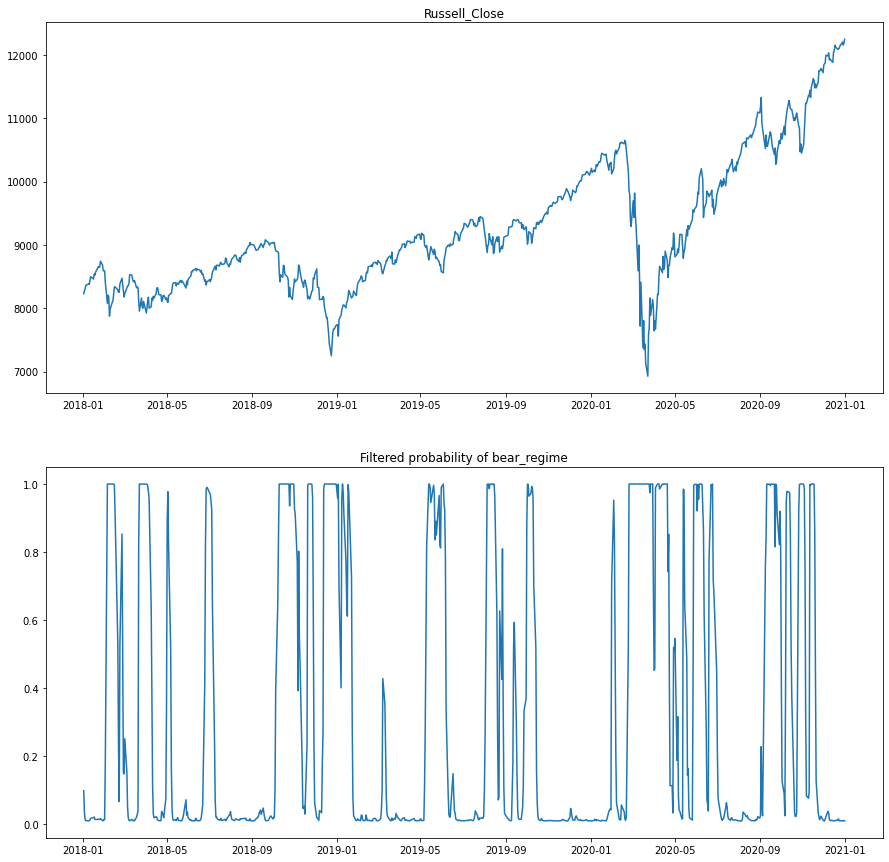

In [106]:
#using the same probability filter constructed from the training set
hmm1_test = sm.tsa.MarkovRegression(endog=df_test[name], k_regimes=2,trend='c',
                                    switching_variance=True)
hmm1_test_results = hmm1_test.fit(start_params = hmm1_results.params, maxiter = 0)
plotProb_test(hmm1_test_results)

In [107]:
duration_static, duration_bear = 2, 4
t1,t2 = Search_train(hmm1_results, duration_static, duration_bear)
print(t1,t2)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:112: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.


0.98 0.15


In [108]:
label_filtered = labeling(hmm1_results,t1,t2)
print((duration(label_filtered))[0].mean())
print((duration(label_filtered))[1].mean())
print((duration(label_filtered))[2].mean())
print((duration(label_filtered))[3])
print(df_train['log_ret'].sum(), label_train_logret(label_filtered))

0    15.956522
dtype: float64
0    4.258065
dtype: float64
0    4.5
dtype: float64
248
1.02974414528519 2.0490072521895546


In [109]:
np.histogram(label_filtered)

(array([ 252,    0,    0,    0,    0,  528,    0,    0,    0, 1100]),
 array([-1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ]))

In [110]:
label_filtered_test = labeling(hmm1_test_results,t1,t2)
print((duration(label_filtered))[0].mean())
print((duration(label_filtered))[1].mean())
print((duration(label_filtered))[2].mean())
print((duration(label_filtered))[3])
print(df_test['log_ret'].sum(), label_test_logret(label_filtered_test))

0    15.956522
dtype: float64
0    4.258065
dtype: float64
0    4.5
dtype: float64
248
0.4205309960530377 0.9393650660947883


In [111]:
label_train= np.array(label_filtered)
label_test= np.array(label_filtered_test)
df_train['hmm1 state'] = label_train
df_test['hmm1 state'] = label_test

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


## DNN

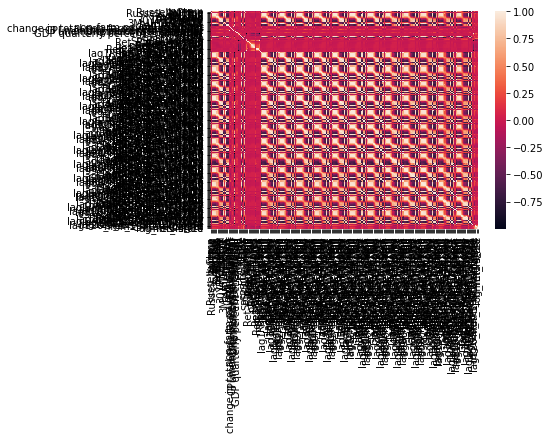

In [ ]:
import seaborn as sns
%matplotlib inline

Var_Corr = df_train.corr()
# plot the heatmap and annotation on it
sns.heatmap(Var_Corr, xticklabels=Var_Corr.columns, yticklabels=Var_Corr.columns)

In [ ]:
df_train.columns

Index(['Russell_Close', 'Russell_Volume', '1MTBill', '3MTBill', '6MTBill',
       '1YTBill', '3YTNotes', '5YTNotes', '10YTNotes', '30YTTreasury',
       ...
       'lag120_Ret_T10Y2Y', 'lag120_Ret_3M_USD_LIBOR',
       'lag120_Ret_WTI_Futures', 'lag120_Ret_WTI_Spot',
       'lag120_Ret_SP500_Close', 'lag120_Ret_SP500_Volume', 'log_ret',
       'hmm1 filtered state', 'log_ret_MA10', 'hmm1 state'],
      dtype='object', length=242)

In [ ]:
dep_var = ['PX_LAST', 'PX_VOLUME', '1MTBill', '3MTBill', '6MTBill', '1YTBill',
       '3YTNotes', '5YTNotes', '10YTNotes', '30YTTreasury', 'Fed_eff_Rate', 'WTI_Futures', 'WTI_Spot',
       'non-farm payroll calendar', 'change in total non-farm(in thousands)',
       'CPI calendar', 'CPI monthly percent change(%)',
       'unemployment rate calendar', 'Unemployment rate(%)', 'GDP calendar',
       'GDP quarterly percent change(%)', 'log_ret', 'hmm1 state']

In [112]:
train_features = df_train
test_features = df_test

train_features['hmm1 state'] = train_features['hmm1 state']+1
test_features['hmm1 state'] = test_features['hmm1 state']+1

train_labels = train_features['hmm1 state'].shift(-1)
test_labels = test_features['hmm1 state'].shift(-1)

train_features = train_features[:-1]
test_features = test_features[:-1]
train_labels = train_labels.dropna()
test_labels = test_labels.dropna()

train_features.describe().transpose()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


,count,mean,std,min,25%,50%,75%,max
Russell_Close,1879.0,5.143449e+03,1.410336e+03,2.746320e+03,3.728590e+03,5.364620e+03,6.138715e+03,8.205060e+03
Russell_Volume,1879.0,1.095283e+09,3.388599e+08,3.694230e+08,9.141393e+08,1.029210e+09,1.188696e+09,3.536062e+09
1MTBill,1879.0,1.818143e-01,2.814112e-01,-2.800000e-02,2.000000e-02,5.800000e-02,1.930000e-01,1.238000e+00
3MTBill,1879.0,2.153273e-01,3.160246e-01,-1.300000e-02,3.000000e-02,8.100000e-02,2.420000e-01,1.442000e+00
6MTBill,1879.0,2.899670e-01,3.458658e-01,2.300000e-02,7.900000e-02,1.370000e-01,3.980000e-01,1.540000e+00
...,...,...,...,...,...,...,...,...
lag120_Ret_SP500_Volume,1879.0,3.777520e+09,8.564559e+08,1.025000e+09,3.271260e+09,3.659010e+09,4.175475e+09,1.061781e+10
log_ret,1879.0,5.509011e-04,9.221268e-03,-7.281862e-02,-3.354903e-03,6.370535e-04,5.061716e-03,4.983430e-02
hmm1 filtered state,1879.0,4.938797e-01,8.189969e-01,-1.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
log_ret_MA10,1879.0,5.623137e-04,2.567529e-03,-1.898468e-02,-7.229431e-04,7.056212e-04,2.122365e-03,9.432762e-03


In [113]:
train_features.dtypes

Russell_Close              float64
Russell_Volume             float64
1MTBill                    float64
3MTBill                    float64
6MTBill                    float64
                            ...   
lag120_Ret_SP500_Volume    float64
log_ret                    float64
hmm1 filtered state          int64
log_ret_MA10               float64
hmm1 state                   int64
Length: 242, dtype: object

In [119]:
def build_and_compile_model(norm):
  model = keras.Sequential([
      norm,
      layers.Dense(16, activation='sigmoid'),
      layers.Normalization(),
      layers.Dense(8, activation='sigmoid'),
      layers.Normalization(),
      layers.Dense(8, activation='sigmoid'),
      layers.Dense(3)
  ])

  model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                optimizer=tf.keras.optimizers.Adam(0.0001),metrics=['Accuracy'])
  return model

In [120]:
normalizer = tf.keras.layers.Normalization(axis=-1)
normalizer.adapt(np.array(train_features))

In [121]:
dnn_model = build_and_compile_model(normalizer)
dnn_model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_32 (Normaliza  (None, 242)              485       
 tion)                                                           
                                                                 
 dense_42 (Dense)            (None, 16)                3888      
                                                                 
 normalization_33 (Normaliza  (None, 16)               33        
 tion)                                                           
                                                                 
 dense_43 (Dense)            (None, 8)                 136       
                                                                 
 normalization_34 (Normaliza  (None, 8)                17        
 tion)                                                           
                                                     

In [122]:
history = dnn_model.fit(
    train_features,
    train_labels,
    validation_split=0.2,
    verbose=1, epochs=200)

Epoch 1/200
47/47 [==============================] - 2s 21ms/step - loss: 1.0963 - Accuracy: 0.5649 - val_loss: 1.0758 - val_Accuracy: 0.6676
Epoch 2/200
47/47 [==============================] - 0s 9ms/step - loss: 1.0847 - Accuracy: 0.5649 - val_loss: 1.0686 - val_Accuracy: 0.6676
Epoch 3/200
47/47 [==============================] - 0s 7ms/step - loss: 1.0739 - Accuracy: 0.5649 - val_loss: 1.0609 - val_Accuracy: 0.6676
Epoch 4/200
47/47 [==============================] - 0s 6ms/step - loss: 1.0641 - Accuracy: 0.5649 - val_loss: 1.0523 - val_Accuracy: 0.6676
Epoch 5/200
47/47 [==============================] - 0s 6ms/step - loss: 1.0549 - Accuracy: 0.5649 - val_loss: 1.0432 - val_Accuracy: 0.6676
Epoch 6/200
47/47 [==============================] - 0s 5ms/step - loss: 1.0464 - Accuracy: 0.5649 - val_loss: 1.0340 - val_Accuracy: 0.6676
Epoch 7/200
47/47 [==============================] - 0s 5ms/step - loss: 1.0384 - Accuracy: 0.5649 - val_loss: 1.0255 - val_Accuracy: 0.6676
Epoch 8/200


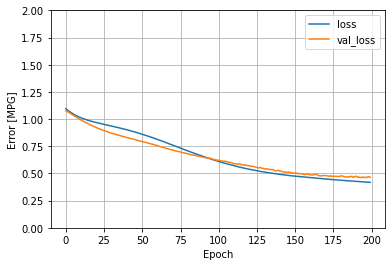

In [123]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 2])
  plt.xlabel('Epoch')
  plt.ylabel('Error [MPG]')
  plt.legend()
  plt.grid(True)
plot_loss(history)

In [124]:
test_loss, test_acc = dnn_model.evaluate(test_features,  test_labels, verbose=2)

print('\nTest accuracy:', test_acc)

24/24 - 0s - loss: 0.8875 - Accuracy: 0.6255 - 73ms/epoch - 3ms/step

Test accuracy: 0.6254979968070984


In [125]:
probability_model = tf.keras.Sequential([dnn_model, tf.keras.layers.Softmax()])

In [126]:
predictions = probability_model.predict(test_features)
predictions[0]

array([0.00838863, 0.05367962, 0.9379317 ], dtype=float32)

In [127]:
test_label_dnn = []
for i in predictions:
  if i[0]> max(i[1],i[2]):
    test_label_dnn.append(0)
  elif i[1]> max(i[0],i[2]):
    test_label_dnn.append(1)
  else:
    test_label_dnn.append(2)
test_label_dnn = np.array(test_label_dnn)

In [128]:
y_ = test_labels  # for eg: [1, 2, 4]
y = test_label_dnn # for eg: [2, 2, 4]
tf.math.confusion_matrix(labels=y_, predictions=y)

<tf.Tensor: shape=(3, 3), dtype=int32, numpy=
array([[ 21,  74,  46],
       [  1,  24, 128],
       [  0,  33, 426]], dtype=int32)>

In [ ]:
test_label_dnn = [1,]
for i in predictions:
  if i[0]> max(i[1],i[2]):
    test_label_dnn.append(-1)
  elif i[1]> max(i[0],i[2]):
    test_label_dnn.append(0)
  else:
    test_label_dnn.append(1)
test_label_dnn = np.array(test_label_dnn)
(df_test['log_ret'] * test_label_dnn).sum()

0.34965511580919895

In [ ]:
df_test['log_ret'].sum()

0.40602371532872183

## GRU

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(train_features)
scaled_train = scaler.transform(train_features)
scaled_test = scaler.transform(test_features)

In [ ]:
train_features.shape

(2013, 23)

In [ ]:
from keras.preprocessing.sequence import TimeseriesGenerator
# define generator
n_input = 30
n_features = 23
generator = TimeseriesGenerator(scaled_train, train_labels, length=n_input, batch_size=1)

In [ ]:
X,y = generator[0]
print(f'Given the Array: \n{X.flatten()}')
print(f'Predict this y: \n {y}')

Given the Array: 
[0.04618491 0.3653034  0.05845182 0.05773196 0.10217535 0.18828452
 0.7410817  0.93268787 0.9175845  0.9233871  0.05797101 0.63337893
 0.629961   0.         0.3473424  0.         0.83333333 0.
 1.         0.         0.46376812 0.6172409  1.         0.04684537
 0.33853717 0.04028436 0.05910653 0.09822017 0.19127316 0.75086306
 0.94329184 0.92973794 0.93804985 0.05797101 0.6494528  0.65037853
 0.         0.3473424  0.         0.83333333 0.         1.
 0.         0.46376812 0.60383364 1.         0.04909454 0.37608708
 0.04423381 0.04742268 0.08833223 0.18410042 0.73820483 0.93822038
 0.93087733 0.94464809 0.04347826 0.64352485 0.64395504 0.
 0.3473424  0.         0.83333333 0.         1.         0.
 0.46376812 0.62812386 1.         0.05080811 0.2976326  0.03396524
 0.04536082 0.0784443  0.15780036 0.73130035 0.93822038 0.94113179
 0.9611437  0.05072464 0.64455084 0.64647855 1.         0.
 0.         0.83333333 1.         1.         0.         0.46376812
 0.61982835 1.   

In [ ]:
X.shape

(1, 30, 23)

In [ ]:
def build_and_compile_model_GRU():
  model = keras.Sequential([
      layers.GRU(8,input_shape=(n_input, n_features),return_sequences=True),
      layers.SimpleRNN(8),
      layers.Dense(16, activation='relu'),
      layers.Dense(3)
      layers.softmax
  ])

  model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                optimizer=tf.keras.optimizers.Adam(0.0001),metrics=['accuracy'])
  return model

In [ ]:
gru_model = build_and_compile_model_GRU()
gru_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 30, 8)             792       
                                                                 
 simple_rnn (SimpleRNN)      (None, 8)                 136       
                                                                 
 dense_4 (Dense)             (None, 16)                144       
                                                                 
 dense_5 (Dense)             (None, 3)                 51        
                                                                 
Total params: 1,123
Trainable params: 1,123
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history_gru = gru_model.fit(
    generator,verbose=1, epochs=100)

Epoch 1/100
1983/1983 [==============================] - 41s 19ms/step - loss: 1.0926 - accuracy: 0.4443
Epoch 2/100
1983/1983 [==============================] - 36s 18ms/step - loss: 0.9165 - accuracy: 0.6137
Epoch 3/100
1983/1983 [==============================] - 37s 19ms/step - loss: 0.8840 - accuracy: 0.6152
Epoch 4/100
1983/1983 [==============================] - 35s 17ms/step - loss: 0.7802 - accuracy: 0.7206
Epoch 5/100
1983/1983 [==============================] - 35s 17ms/step - loss: 0.7040 - accuracy: 0.7595
Epoch 6/100
1983/1983 [==============================] - 37s 19ms/step - loss: 0.6599 - accuracy: 0.7605
Epoch 7/100
1983/1983 [==============================] - 36s 18ms/step - loss: 0.6302 - accuracy: 0.7680
Epoch 8/100
1983/1983 [==============================] - 37s 19ms/step - loss: 0.6075 - accuracy: 0.7756
Epoch 9/100
1983/1983 [==============================] - 38s 19ms/step - loss: 0.5905 - accuracy: 0.7821
Epoch 10/100
1983/1983 [==============================]

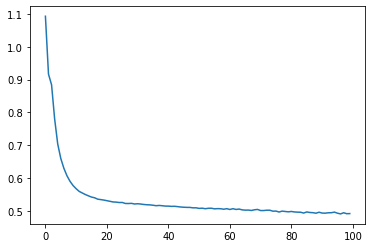

In [ ]:
loss_per_epoch = gru_model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

In [ ]:
generator = TimeseriesGenerator(scaled_test, test_labels, length=n_input, batch_size=1)

In [ ]:
test_loss, test_acc = gru_model.evaluate(generator, verbose=2)

print('\nTest accuracy:', test_acc)

725/725 - 3s - loss: 0.9680 - accuracy: 0.7241 - 3s/epoch - 5ms/step

Test accuracy: 0.7241379022598267


In [ ]:
predictions = gru_model.predict(generator)

In [ ]:
test_label_gru = [1,]
for i in predictions:
  if i[0]> max(i[1],i[2]):
    test_label_gru.append(-1)
  elif i[1]> max(i[0],i[2]):
    test_label_gru.append(0)
  else:
    test_label_gru.append(1)
test_label_gru = np.array(test_label_gru)
(df_test['log_ret'][30:] * test_label_gru).sum()

0.01753087497245609